In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models.resnet as resnet
import common_utils
import os

In [2]:
%matplotlib inline

In [3]:
model = resnet.resnet18()
model.load_state_dict(torch.load('pytorch_pretrained_resnet_model_80e'))
model = model.eval()

In [2]:
model = resnet.resnet18(pretrained=True).eval()

The paper visualized neurons via two methods: looking at the kernels, and using gradient ascent to create an image to maximize the score of a particular artist.

In [5]:
blocks = [*model.layer1, *model.layer2, *model.layer3, *model.layer4]

layers = [[b.conv1, b.conv2] for b in blocks]

layers = [l for group in layers for l in group]

In [6]:
weights = layers[0].weight.detach()

In [7]:
weights.size()

torch.Size([64, 64, 3, 3])

In [8]:
layers[-1]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [9]:
# fig, axarr = plt.subplots(weights[0].size(0))
# WIP to get this working again
# for i in range(weights[0].size(0)):
#     axarr[i].imshow(weights[0, i].squeeze())
    


## Gradient Ascent

In [3]:
import visualize
import cv2
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
import copy
from PIL import Image

In [4]:
import common_utils
label_to_artist, artist_to_label = common_utils.init_label_dicts()

In [86]:
def preprocess(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    im_arr = np.float32(image)
    im_arr = im_arr.transpose(2, 0 ,1)
    
    im_arr /= 255
    for channel in range(len(im_arr)):
        im_arr[channel] -= mean[channel]
        im_arr /= std[channel]
    im_tensor = torch.from_numpy(im_arr).float().cuda()
    im_tensor.unsqueeze_(0)
    im_var = Variable(im_tensor, requires_grad=True)
    return im_var

def denormalize(image):
    r_mean = [-0.485, -0.456, -0.406]
    r_std = [1/0.229, 1/0.224, 1/0.225]
    recreated = copy.copy(image.numpy()[0])
    for channel in range(len(recreated)):
        recreated /= r_std[channel]
        recreated[channel] -= r_mean[channel]
    recreated = np.clip(recreated, 0, 1)
    recreated = np.round(recreated * 255)
    recreated = np.uint8(recreated).transpose(1,2,0)
    return recreated

In [87]:
artist = 'Pablo Picasso'
upscaling_steps = 12
upscaling_factor = 1.2
size = 224
lr = 0.1
label_to_artist, artist_to_label = common_utils.init_label_dicts()
label = artist_to_label[artist]

/home/cole/miniconda3/envs/sci/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


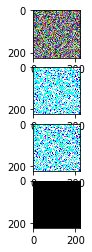

In [94]:
label = 130
model = model.cuda().eval()
img = visualize.generate_random_image(size=size)
preprocessed = preprocess(img).detach().cpu().numpy().squeeze().transpose(1,2,0)
recreated = denormalize(torch.tensor(preprocess(img).cpu()))
#print(np.array(img))
#print(preprocessed)

fig, ax_arr = plt.subplots(4)
ax_arr[0].imshow(img)
ax_arr[1].imshow(preprocessed)
ax_arr[2].imshow(recreated)
ax_arr[3].imshow(preprocessed - recreated)

In [55]:
# for _ in range(upscaling_steps):
#     img_var = Variable(
#         common_utils.train_loader_transform(img).cuda().view(1,3,224,224),
#         requires_grad=True
#     )
    
for n in range(250):
    img_var = preprocess(img)
    optimizer = torch.optim.SGD([img_var], lr=0.1)
    optimizer.zero_grad()
    
    outputs = model(img_var)
    loss = -outputs[0, label]
    model.zero_grad()
    loss.backward()
#     if n == 0 or n % 50 == 0:
#         print(loss)
#         print(img_var)
#         print(img_var.grad.cpu().numpy().squeeze().transpose(1,2,0))
    optimizer.step()
    img = denormalize(img_var.detach().cpu())
    #size = int(upscaling_factor * size)
    #img = Image.fromarray(cv2.resize(img, (size, size), interpolation = cv2.INTER_CUBIC))

In [31]:
# res = recreate(img)

In [32]:
img

array([[[  0,  35, 255],
        [  0, 211, 255],
        [  0,  76, 255],
        ...,
        [  0, 239, 255],
        [  0, 150, 255],
        [  0, 110, 255]],

       [[  0,  88, 255],
        [  0, 156, 255],
        [  0, 201, 255],
        ...,
        [  0, 143, 255],
        [  0, 199, 255],
        [  0, 238, 255]],

       [[  0, 205, 255],
        [  0, 166, 255],
        [  0, 216, 255],
        ...,
        [  0, 219, 255],
        [  0, 172, 255],
        [  0,  45, 255]],

       ...,

       [[  0, 189, 255],
        [  0,   7, 255],
        [  0,  89, 255],
        ...,
        [  0, 131, 255],
        [  0,  62, 255],
        [  0,  41, 255]],

       [[  0,   7, 255],
        [  0, 192, 255],
        [  0,  36, 255],
        ...,
        [  0,  71, 255],
        [  0, 231, 255],
        [  0, 179, 255]],

       [[  0, 123, 255],
        [  0,  11, 255],
        [  0, 101, 255],
        ...,
        [  0, 173, 255],
        [  0, 216, 255],
        [  0,  53, 255]]

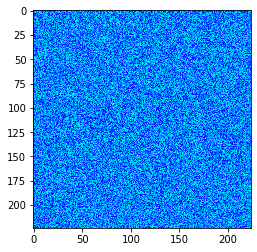

In [33]:
plt.imshow(img)

In [ ]:
# plt.imsave('van_gogh_transformed.png', res)